In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [ ]:
# File path for the CSV file
file_path = r'C:\Users\maiks\OneDrive\Desktop\Uni\WiSe24\SAIA\elec_prices_belg_50.csv'    ##### INPUT DATA CAN BE CHANGED HERE

In [3]:
# Load the CSV file into a DataFrame
data = pd.read_csv(file_path, sep=';', header=None)
data.columns = ['Electricity Price', 'Binary Column', 'Unused1', 'Unused2']
# Convert the 'Electricity Price' column to numeric values
data['Electricity Price'] = pd.to_numeric(data['Electricity Price'], errors='coerce')

# Drop rows with invalid or missing electricity prices (if any)
data = data.dropna(subset=['Electricity Price'])

# Filter relevant data
electricity_prices = data['Electricity Price'].values
# Filter relevant data
electricity_prices = data['Electricity Price'].values

In [4]:
# Constants
f_out = 625 # Constant outflow rate in m³/h
initial_volume = 0  # Initial tank volume in m³
maxtank = 50000

# Electrolyzer configuration
rated_power_mw = 100  # Rated power of the electrolyzer in MW (modifiable)
electrolyzer_efficiency = 0.75  # 75% efficiency
energy_per_kg_h2 = 33.33  # Energy content of H2 in kWh/kg
density_h2 = 0.08988  # Density of hydrogen gas in kg/m³ at STP

In [5]:
# Calculate maximum hydrogen production rate in m³/h based on rated power
effective_power_kw = rated_power_mw * 1000 * electrolyzer_efficiency  # Convert MW to kW and apply efficiency
max_h2_production_kg_h = effective_power_kw / energy_per_kg_h2  # Maximum hydrogen production in kg/h
f_in_max = max_h2_production_kg_h / density_h2  # Convert to m³/h

# Time array (assuming one entry per hour)
time_hours = np.arange(len(electricity_prices))

# Function to determine electrolyzer capacity based on electricity price
def determine_capacity_binary(price):
    return 100 if price < 50 else 0

# Generate inflow pattern based on electricity prices (binary production)
inflow_pattern = np.array([determine_capacity_binary(price) for price in electricity_prices])


In [6]:
def determine_capacity_variable(price):
    """
    Determine the electrolyzer capacity based on the electricity price.

    Parameters:
    price (float): Electricity price.

    Returns:
    int: Percentage capacity of the electrolyzer (0-100%).
    """
    if price < 20:
        return 100  # Full capacity
    elif 20 <= price < 25:
        return 80  # 80% capacity
    elif 25 <= price < 30:
        return 60  # 60% capacity
    elif 30 <= price < 35:
        return 40  # 40% capacity
    elif 35 <= price < 50:
        return 20  # 20% capacity
    else:
        return 0  # No production

# Generate inflow pattern based on electricity prices
inflow_pattern_Variable = np.array([determine_capacity_variable(price) for price in electricity_prices])


In [7]:
import csv

def read_column_from_csv(filename, column_index):
    """Liest die angegebene Spalte aus einer CSV-Datei und gibt sie als Liste zurück."""
    numbers = []
    with open(filename, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        next(reader)  # Überspringt die Kopfzeile, wenn vorhanden
        for row in reader:
            try:
                numbers.append(int(row[column_index]))  # Konvertiert Werte zu Ganzzahlen
            except (IndexError, ValueError):
                continue  # Ignoriere ungültige Werte
    return numbers

# Pfad zur CSV-Datei
csv_filename = file_path  # Beispiel: Dateipfad anpassen
column_index = 1  # Spalte mit den binären Werten

# Spaltenwerte auslesen
binary_series = read_column_from_csv(csv_filename, column_index)

In [8]:
# Hydrogen production function
def hydrogen_production(percent_capacity):
    """
    Calculate the amount of hydrogen produced by the electrolyzer
    based on the percentage of rated capacity.

    Parameters:
    percent_capacity (float): The percentage of rated capacity (0-100%).

    Returns:
    float: The hydrogen production rate in m³/hour.
    """
    # Calculate the effective power based on percent capacity
    effective_power = (percent_capacity / 100) * effective_power_kw

    # Calculate the hydrogen production in kg/h
    h2_production_rate_kg_h = effective_power / energy_per_kg_h2

    # Convert to m³/h
    h2_production_rate_m3_h = h2_production_rate_kg_h / density_h2

    return h2_production_rate_m3_h

# Calculate hydrogen production rates
h2_production_onoff = np.array((determine_capacity_binary_one(price)) for price in electricity_prices)
#h2_production_rates = np.array([hydrogen_production(determine_capacity_binary(price)) for price in electricity_prices])
def determine_capacity_binary_one(price):
    return 1 if price < 50 else 0

pf = 18.75
binary_series_array = np.array(binary_series)
h2_production_rates = rated_power_mw*pf*binary_series_array

# Manual integration function for hydrogen tank volume
def calculate_tank_volume_manual(time_hours, h2_production_rates, f_out, initial_volume):
    volumes = np.zeros_like(time_hours, dtype=float)
    volumes[0] = initial_volume

    for i in range(1, len(time_hours)):
        if i >= len(h2_production_rates):
            break  # Prevent indexing out of bounds
        dt = 1  # Each row represents 1 hour
        inflow = h2_production_rates[i]        # Current inflow rate
        outflow = f_out                        # Outflow is constant
        dV = (inflow - outflow) * dt           # Change in volume
        volumes[i] = max(0, volumes[i - 1] + dV)
        volumes[i] = min(maxtank, volumes[i - 1] + dV)   # Update volume, ensure it's not above 50 tons

    return volumes

In [9]:
# Calculate tank volumes
tank_volumes = calculate_tank_volume_manual(time_hours, h2_production_rates, f_out, initial_volume)
tank_volume_0 = calculate_tank_volume_manual(time_hours, h2_production_rates, 0, initial_volume)


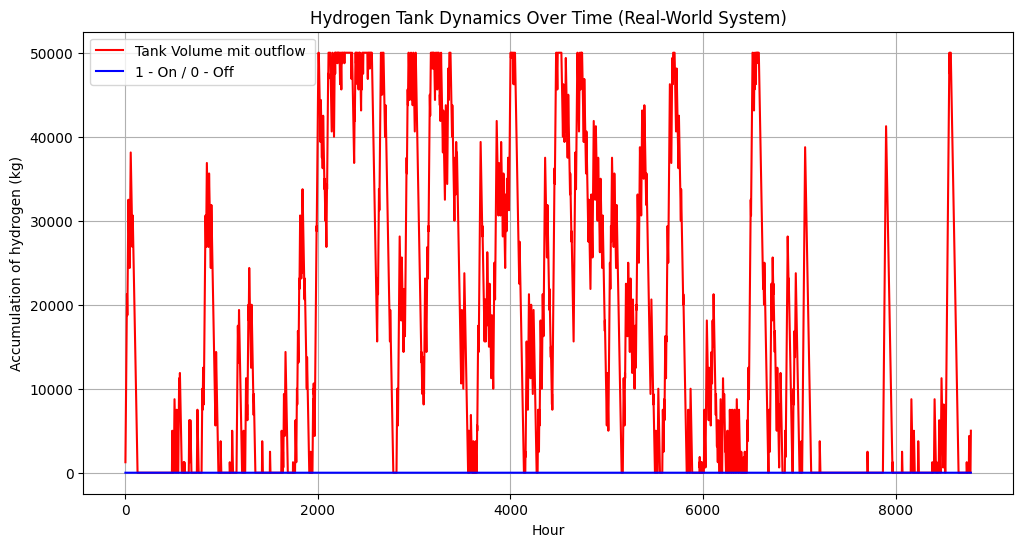

In [10]:
# pplot for only 2024
time_hours_2024 = np.arange(8784)
h2_production_rates_2024 = h2_production_rates[26288:len(h2_production_rates)]
binary_series_2024 = binary_series[26288:len(binary_series)]

def calculate_tank_volume_manual_2024(time_hours_2024, h2_production_rates, f_out, initial_volume):
    volumes = np.zeros_like(time_hours_2024, dtype=float)
    volumes[0] = initial_volume

    for i in range(0, len(time_hours_2024)):
        if i >= len(h2_production_rates_2024):
            break  # Prevent indexing out of bounds
        dt = 1  # Each row represents 1 hour
        inflow = h2_production_rates_2024[i]        # Current inflow rate
        outflow = f_out                        # Outflow is constant
        dV = (inflow - outflow) * dt           # Change in volume
        volumes[i] = max(0, min(maxtank, volumes[i - 1] + dV))
        #volumes[i] = max(0, volumes[i - 1] + dV)   # Update volume, ensure it's not negative
        #volumes[i] = min(50000, volumes[i - 1] + dV)  # Update volume, ensure it's not above some value
  

    return volumes


# Calculate tank volumes
tank_volumes_2024 = calculate_tank_volume_manual_2024(time_hours_2024, h2_production_rates, f_out, initial_volume)
tank_volume_0_2024 = calculate_tank_volume_manual_2024(time_hours_2024, h2_production_rates, 0, initial_volume)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(time_hours_2024, tank_volumes_2024, label='Tank Volume mit outflow ', color='r')
plt.plot(time_hours_2024, binary_series_2024, label='1 - On / 0 - Off ', color='b')
#plt.plot(time_hours_2024, tank_volume_0_2024, label='Tank Volume ohne outflow', color='r')
plt.xlabel('Hour')
plt.ylabel('Accumulation of hydrogen (kg)')
plt.title('Hydrogen Tank Dynamics Over Time (Real-World System)')
plt.legend()
plt.grid()
plt.show()

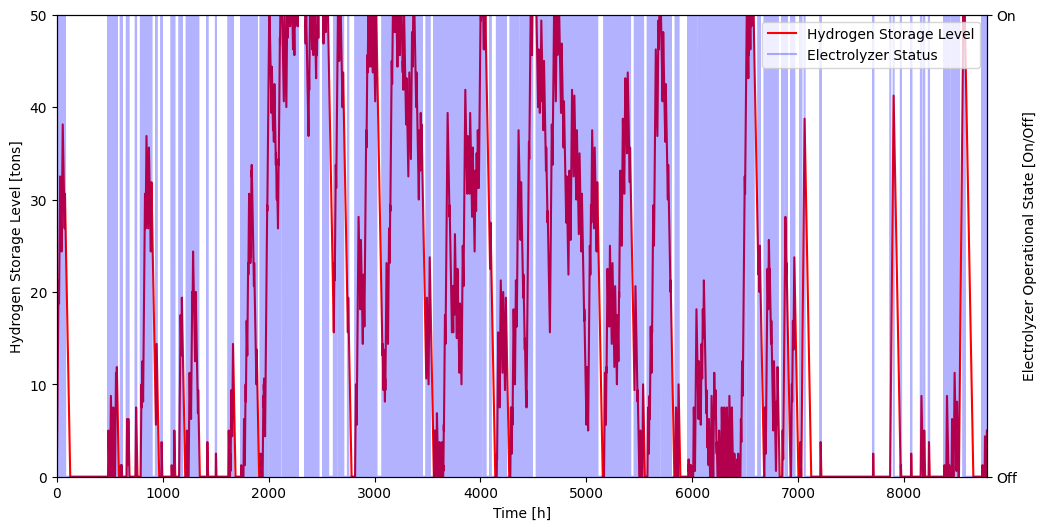

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Zweite Achse für Binary Series
ax2 = ax1.twinx()
ax2.plot(time_hours_2024, binary_series_2024, label='Electrolyzer Status', color='b', alpha = 0.3)
ax2.set_ylabel('Electrolyzer Operational State [On/Off]')
ax2.tick_params(axis='y')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(["Off", "On"])
ax2.set_ylim(0, 1)

# Erste Achse für Tankvolumen
ax1.plot(time_hours_2024, tank_volumes_2024, label='Hydrogen Storage Level', color='r')
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Hydrogen Storage Level [tons]')
ax1.tick_params(axis='y')
#ax1.grid(False)

def kg_to_tonnes(x, pos):
    return f"{x / 1000:.0f}"  # Teilt kg durch 1000 und zeigt eine Nachkommastelle

ax1.yaxis.set_major_formatter(FuncFormatter(kg_to_tonnes))  # Formatter anwenden
ax1.tick_params(axis='y')
ax1.grid(False)

# X-Achse nur auf den Bereich mit Daten begrenzen
ax1.set_xlim(min(time_hours_2024), max(time_hours_2024))
ax1.set_ylim(min(tank_volumes_2024), max(tank_volumes_2024))  # Y-Achse dynamisch setzen

# Legenden zusammenführen
fig.legend(loc="upper right",bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes) # 

# Titel und Anzeige
#plt.title('Hydrogen Tank Dynamics Over Time (Real-World System)')
plt.show()


In [12]:
z = max(tank_volumes_2024)
print(z)

print(tank_volumes_2024)

50000.0
[1250. 2500. 3750. ... 2500. 3750. 5000.]


In [13]:
# Beispielzeitreihe (hier musst du deine Daten einfügen)
#time_series = [1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 3]

# Anzahl der Einträge mit dem Wert 0
def count_zeros_and_sequences(time_series):
    total_zeros = 0  # Gesamte Anzahl der Nullen
    zero_sequences = 0  # Anzahl der zusammenhängenden Null-Sequenzen
    in_zero_sequence = False  # Flag, ob wir uns in einer Null-Sequenz befinden

    for value in time_series:
        if value == 0:
            total_zeros += 1
            if not in_zero_sequence:
                zero_sequences += 1
                in_zero_sequence = True
        else:
            in_zero_sequence = False

    return total_zeros, zero_sequences

# Ergebnisse berechnen
total_zeros, zero_sequences = count_zeros_and_sequences(tank_volumes_2024)

print(f"Gesamte Anzahl der Nullen: {total_zeros}")
print(f"Anzahl der zusammenhängenden Null-Sequenzen: {zero_sequences}")


Gesamte Anzahl der Nullen: 2816
Anzahl der zusammenhängenden Null-Sequenzen: 82


In [14]:

# Anzahl der Einträge mit dem Wert 0
def count_zeros_and_sequences(time_series):
    total_zeros = 0  # Gesamte Anzahl der Nullen
    zero_sequences = 0  # Anzahl der zusammenhängenden Null-Sequenzen
    in_zero_sequence = False  # Flag, ob wir uns in einer Null-Sequenz befinden

    for value in time_series:
        if value == 0:
            total_zeros += 1
            if not in_zero_sequence:
                zero_sequences += 1
                in_zero_sequence = True
        else:
            in_zero_sequence = False

    return total_zeros, zero_sequences

# Ergebnisse berechnen
total_zeros, zero_sequences = count_zeros_and_sequences(binary_series_2024)

print(f"Gesamte Anzahl der Nullen ohne Tank: {total_zeros}")
print(f"Anzahl der zusammenhängenden Null-Sequenzen ohne Tank: {zero_sequences}")

Gesamte Anzahl der Nullen ohne Tank: 6442
Anzahl der zusammenhängenden Null-Sequenzen ohne Tank: 325


In [15]:
def berechne_tankvolumen(masse, druck, temperatur, molare_masse=0.002016, gaskonstante=8.314):
    """
    Berechnet das Tankvolumen für Wasserstoff unter gegebenen Bedingungen.

    :param masse: Masse des Wasserstoffs in kg
    :param druck: Druck in Pascal (Pa)
    :param temperatur: Temperatur in Kelvin (K)
    :param molare_masse: Molare Masse von Wasserstoff in kg/mol (Standard: 0.002016 kg/mol)
    :param gaskonstante: Universelle Gaskonstante in J/(mol·K) (Standard: 8.314)
    :return: Tankvolumen in m³
    """
    # Berechne die Stoffmenge n
    stoffmenge = masse / molare_masse
    
    # Berechne das Volumen V
    volumen = (stoffmenge * gaskonstante * temperatur) / druck
    return volumen


# Eingabewerte
masse = z           # Masse des Wasserstoffs in kg
druck = 200 * 10**5         # Druck in Pascal (200 bar)
temperatur = 298.15         # Temperatur in Kelvin (z.B. 25°C)

# Berechnung
volumen = berechne_tankvolumen(masse, druck, temperatur)

# Ausgabe
print(f"Für {masse} kg Wasserstoff bei {druck / 10**5} bar und {temperatur} K beträgt das Tankvolumen:")
print(f"{volumen:.3f} m³")


Für 50000.0 kg Wasserstoff bei 200.0 bar und 298.15 K beträgt das Tankvolumen:
3073.932 m³


In [16]:
def betriebsvolumen_zu_normvolumen(v_betrieb, p_betrieb, t_betrieb, p_norm=101325, t_norm=273.15):
    """
    Rechnet das Betriebsvolumen eines Gases in Normkubikmeter um.

    :param v_betrieb: Volumen unter Betriebsbedingungen (in m³)
    :param p_betrieb: Druck unter Betriebsbedingungen (in Pascal, Pa)
    :param t_betrieb: Temperatur unter Betriebsbedingungen (in Kelvin, K)
    :param p_norm: Normdruck (in Pascal, Pa; Standardwert: 101325 Pa)
    :param t_norm: Normtemperatur (in Kelvin, K; Standardwert: 273.15 K)
    :return: Volumen unter Normbedingungen (in Nm³)
    """
    # Umrechnung mit der idealen Gasgleichung
    v_norm = v_betrieb * (p_betrieb / p_norm) * (t_norm / t_betrieb)
    return v_norm


# Beispielwerte
v_betrieb = volumen        # Betriebsvolumen in m³
p_betrieb = 200*10**5   # Betriebsdruck in Pascal (z.B. 2000 hPa)
t_betrieb = 293.15     # Betriebstemperatur in Kelvin (z.B. 20°C)

# Umrechnung
v_norm = betriebsvolumen_zu_normvolumen(v_betrieb, p_betrieb, t_betrieb)

# Ergebnis ausgeben
print(f"Betriebsvolumen: {v_betrieb} m³")
print(f"Normvolumen: {v_norm:.3f} Nm³")


Betriebsvolumen: 3073.9324156746034 m³
Normvolumen: 565352.093 Nm³
